In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.core.display import display
from PIL import Image
from matplotlib.ticker import NullLocator
import numpy as np
import glob
import pandas as pd
import json
import os
from sklearn import preprocessing
from skimage.metrics import structural_similarity as ssim  # Need >= Version 0.16.1
from skimage.metrics import mean_squared_error
from rpy2.robjects.packages import importr
import rpy2.robjects as R
import statistics as pys
from os.path import exists
import pickle
stats = importr("stats")

game_titles = {
    "shuffleKeys_game": "Switching Mappings Game",
    "contingency_game": "Contingency Game",
    "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
    "contingency_game_shuffled_1": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled": "Switching Mappings Game",
    "logic_game": "Logic Game",
    "logic_extended_game": "Ext Logic",
    "change_agent_game": "Switching Embodiments Game"
}

agent_titles = {'human': 'Human', 'self_class': 'Self Class', 'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'acer_training': 'ACER', 'ppo2_training': 'PPO2', 'dqn_training': 'DQN', 'option_critic': 'OC'}

agent_types = list(agent_titles.keys())
game_types = ["logic_game", "contingency_game", "contingency_game_shuffled_1"] 


def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

def get_seed_num_and_iter(x):
    if "seed" in x:
        return int(find_between(x.split("/")[4], "seed", "-")) * 1000000000 + int(x.split("/")[-1][6:-5])
    else:
        return int(x.split("/")[4].split("iter")[1]) * 1000000000 + int(x.split("/")[-1][6:-5])


In [4]:

def combine_human_heatmaps(game_name, normalized=False):
    game_f = '_normalized' if normalized else ''
    path = "./plots/heatmaps/" + game_name + "{}/".format(game_f) + "human/" + "*.jpg"
    files = glob.glob(path)

    def get_index(x):
        print(x.split("_"))
        return int(x.split("_")[-2])

    sorted_files = sorted(files, key=get_index)
    images = []
    for file in sorted_files:
        images.append(Image.open(file))

    all_imgs = None
    curr_horiz = images[0]
    for i in range(1, len(images)):
        if i != 0 and i % 5 == 0: # Concatanate vertically
            if all_imgs is None:
                all_imgs = curr_horiz
            else:
                all_imgs = get_concat_v(all_imgs, curr_horiz)
            curr_horiz = images[i]
        else:
            curr_horiz = get_concat_h(curr_horiz, images[i])
    all_imgs = get_concat_v(all_imgs, curr_horiz)

    display(all_imgs)

    path = "./plots/heatmaps/concatenated_human_heatmaps/"
    if not os.path.exists(path):
        os.makedirs(path)


    fs = ""
    if fl100 == 1:
        fs = "first_100"
    elif fl100 == -1:
        fs = "last_100"

    if normalized:
        filename = path + game_name + "_norm_concat{}.jpg".format(fs)
        all_imgs.save(filename, quality=100)
    else:
        filename = path + game_name + "_concat{}.jpg".format(fs)
        all_imgs.save(filename, quality=100)


def combine_heatmaps(game_name, normalized=False, comparison=False, fl100=0, single_row=False):
    fs = ""
    if fl100 == 1:
        fs = "first_100"
    elif fl100 == -1:
        fs = "last_100"

    images = []
    for i in range(len(agent_types)):
        if normalized:
            if comparison:
                if agent_types[i] == 'human':
                    continue
                path = "./plots/heatmaps/comparisons_normalized_avg{}/".format(fs) + game_name + "/{}.jpg".format(agent_types[i])
            else:
                path = "./plots/heatmaps/" + game_name + "_normalized_avg/" + agent_types[i] + "/" + "{}seeds_combined_heatmap.jpg".format(fs)
        else:
            if comparison:
                if agent_types[i] == 'human':
                    continue
                path = "./plots/heatmaps/comparisons_avg{}/".format(fs) + game_name + "/{}.jpg".format(agent_types[i])
            else:
                path = "./plots/heatmaps/" + game_name + "_avg/" + agent_types[i] + "/" + "{}seeds_combined_heatmap.jpg".format(fs)
        if len(glob.glob(path)) == 0:  # if one of the image files do not exist
            print("Cannot concatanate: File " + path + " does not exist.")
            return
        images.append(Image.open(glob.glob(path)[0]))

    if single_row:
        concat_func = get_concat_h
    else:
        concat_func = get_concat_v

    if not comparison:
        h1 = concat_func(images[0], images[1])
        h2 = concat_func(images[2], images[3])
        h3 = concat_func(images[4], images[5])
        h4 = concat_func(images[6],images[7])
    else:
        h1 = concat_func(images[0], images[1])
        h2 = concat_func(images[2], images[3])
        h3 = concat_func(images[4], images[5])
        h4 = images[6]

    combined = get_concat_h(h1, h2)
    combined = get_concat_h(combined, h3)
    combined = get_concat_v(combined, h4) if comparison else get_concat_h(combined, h4)
    display(combined)

    path = "./plots/heatmaps/concatenated_heatmaps_compare/" if comparison else "./plots/heatmaps/concatenated_heatmaps/"
    if not os.path.exists(path):
        os.makedirs(path)

    if normalized:
        filename = path + game_name + "_norm_concat{}.jpg".format(fs)
        combined.save(filename, quality=100)
    else:
        filename = path + game_name + "_concat{}.jpg".format(fs)
        combined.save(filename, quality=100)


# Concatenate vertically
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst


# Concatenate horizontally
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def plot_heatmap(normalize, state_counts, file, game_type, agent_type, avg=False):
    if normalize:
        state_counts = preprocessing.normalize(state_counts)

    plt.imshow(state_counts.T, cmap='viridis')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                        hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    base = os.path.basename(file)

    if normalize and avg:  # Normalized avg.
        path = "./plots/heatmaps/" + game_type + "_normalized_avg/" + agent_type + "/"
    elif normalize and not avg:  # Normalized
        path = "./plots/heatmaps/" + game_type + "_normalized/" + agent_type + "/"
    elif avg and not normalize:  # Avg.
        path = "./plots/heatmaps/" + game_type + "_avg/" + agent_type + "/"
    else:  # Normal with title
        path = "./plots/heatmaps/" + game_type + "/" + agent_type + "/"

    if not os.path.exists(path):
        os.makedirs(path)

    filename = path + os.path.splitext(base)[0] + '_heatmap.jpg'
    print("Saving to: {}".format(filename))
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=500)
    #plt.show()


# fl100 == 0 -> All levels, fl100 == 1 -> First 100 Only, fl100 == -1 -> Last 100 Only
def make_heatmap(game_type, agent_type, normalize=False, fl100=0):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    # Check if saved data exists
    fpath = './heatmap_data/' + game_type + "_" + agent_type + "normalize={}".format(normalize) + "_" + str(fl100) + ".pickle"
    if exists(fpath):
        return pickle.load(open(fpath, 'rb'))

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json") + glob.glob(
            "../data/" + game_type + "/" + agent_type + "/*.json")
    if len(files) == 0:
        return False

    # Skip stress test files
    if agent_type not in ["human", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

    seed = 0
    curr_file_count = 0
    state_counts_sum = []  # Sum of state counts of all seeds
    state_counts_seed = []  # Sum of state counts of a single seed

    def get_state_counts(file, i):
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]
        map = data.get("data")["map"]

        level_amt = 100
        width = len(map[0][0])
        height = len(map[0])

        state_counts = np.zeros((width, height))  # State counts of 100 levels

        # read encountered states
        for level in range(level_amt):
            if len(self_locs[level]) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range(action_amt):
                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                state_counts[x, y] += 1

        # rotate the matrix
        state_counts = np.rot90(state_counts)
        return state_counts, width, height


    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)
    for i, file in enumerate(sorted_files):
        curr_file_count += 1

        if i == 0:
            data = json.load(open(file))
            map = data.get("data")["map"]
            width = len(map[0][0])
            height = len(map[0])
            state_counts = np.zeros((width, height))  # State counts of 100 levels
            state_counts_seed = np.zeros((width, height))
            state_counts_sum = np.zeros((width, height))

        if fl100 == 0 and agent_type != 'human':
            state_counts, w, h = get_state_counts(file, i)
            state_counts_sum += state_counts
            state_counts_seed += state_counts

            if curr_file_count == 20:  # Seed complete
                plot_heatmap(normalize, state_counts_seed, "seed_" + str(seed), game_type, agent_type)
                state_counts_seed = np.zeros((w, h))
                curr_file_count = 0
                seed += 1

        # Plot First 100 of Artificial Agents
        if agent_type != 'human' and ((curr_file_count - 1) % 20 == 0) and fl100 == 1:
            print("First hundred: ", file)
            state_counts, w, h = get_state_counts(file, i)
            state_counts_seed = np.zeros((w, h))
            state_counts_sum += state_counts
            state_counts_seed += state_counts
            plot_heatmap(normalize, state_counts_seed, "first_100_seed_" + str(seed), game_type, agent_type)
            seed += 1

        if agent_type != 'human' and (curr_file_count % 20 == 0) and fl100 == -1:
            print("Last hundred: ", file)
            state_counts, w, h = get_state_counts(file, i)
            state_counts_seed = np.zeros((w, h))
            state_counts_sum += state_counts
            state_counts_seed += state_counts
            plot_heatmap(normalize, state_counts_seed, "last_100_seed_" + str(seed), game_type, agent_type)
            seed += 1


        # Plot Human
        if agent_type == 'human':
            print(file)
            state_counts, w, h = get_state_counts(file, i)
            state_counts_seed = np.zeros((w, h))
            state_counts_seed += state_counts
            state_counts_sum += state_counts
            plot_heatmap(normalize, state_counts_seed, file.split('_')[0] + "_" + str(seed), game_type, agent_type)
            seed += 1

    s = ""
    if fl100 == 1:
        s = "first_100"
    elif fl100 == -1:
        s = "last_100"

    plot_heatmap(normalize, state_counts_sum, "{}seeds_combined".format(s), game_type, agent_type, avg=True)
    return True

In [ ]:
# Create heatmap for option-critic
for fl100 in [1, 0, -1]:
    make_heatmap("logic_game", "trpo_training", normalize=True, fl100=fl100) # Make normalized heatmaps
    make_heatmap("logic_game", "a2c_training", normalize=True, fl100=fl100) # Make normalized heatmaps

In [ ]:

# Make heatmaps for all game and agent types
fl100s = [-1, 0, 1] #, 1, 0
game_types = ["logic_game", "contingency_game", "contingency_game_shuffled_1", "change_agent_game"]
for fl100 in fl100s:
    for game in game_types:
        for agent in agent_types:
            #make_heatmap(game, agent, fl100=fl100)
            make_heatmap(game, agent, normalize=True, fl100=fl100) # Make normalized heatmaps

        #combine_heatmaps(game, fl100=fl100, single_row=True)
        combine_heatmaps(game, normalized=True, fl100=fl100, single_row=True) # Combine normalized heatmaps

        #if fl100 == 1:
        #    combine_human_heatmaps(game, normalized=False)
        #    combine_human_heatmaps(game, normalized=True)


In [5]:
# Source: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


# Source: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
def compare_images(imageA, imageB, game_type, agent_type, title, folder_appx, fl100, plot=True):
    sstr = ""
    if fl100 == 1:
        sstr = "first_100"
    elif fl100 == -1:
        sstr = "last_100"

    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    #m = mean_squared_error(imgA, imgB) # Mean Squared Error (0 = same image)
    s = ssim(imageA, imageB, multichannel=True)  # Structural Similarity (1 = same image). This one is more precise

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s) + " \n" + title + "")

    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap=plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap=plt.cm.gray)
    plt.axis("off")

    # show the images
    if plot:
        plt.show()

        path = "./plots/heatmaps/comparisons_{}{}/".format(folder_appx, sstr) + game_type + "/"
        if not os.path.exists(path):
            os.makedirs(path)

        filename = path + agent_type + ".jpg"
        fig.savefig(filename, format='jpg', dpi=500, )
    return m, s

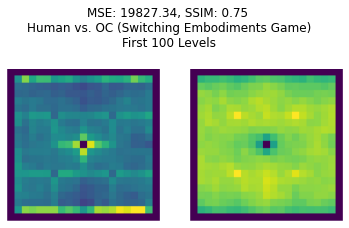

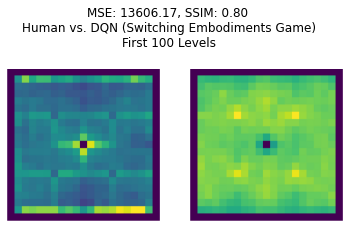

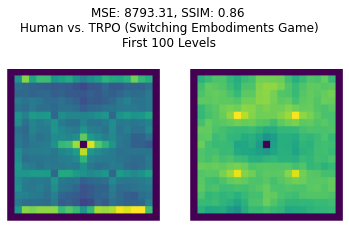

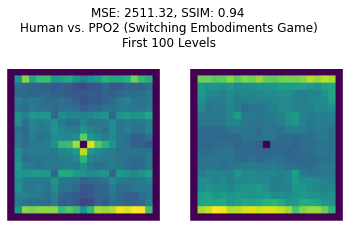

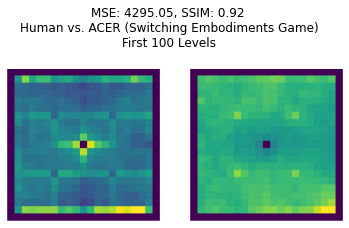

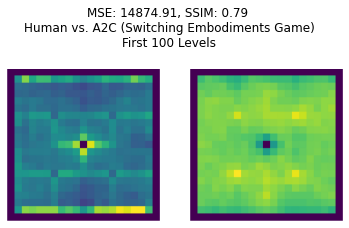

Mean MSE error for change_agent_game = 10651.352186017251 (Normalized, first_100)


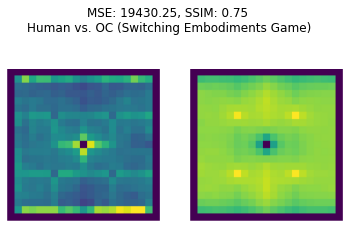

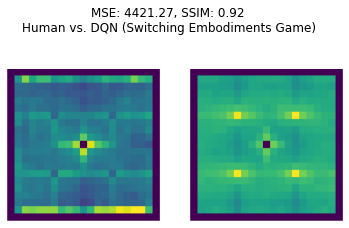

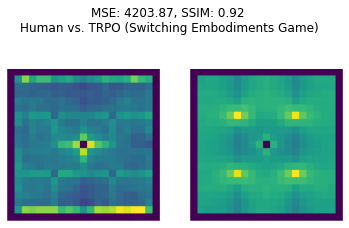

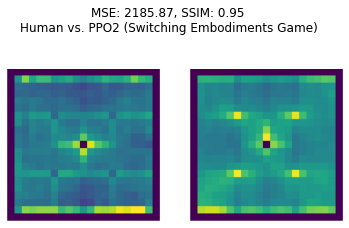

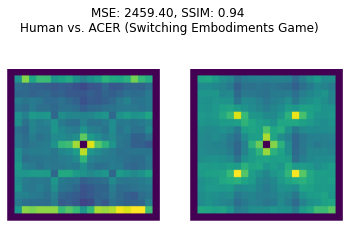

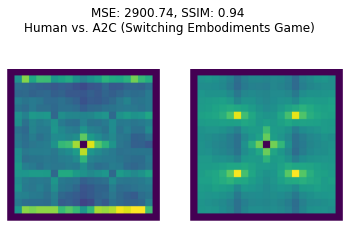

Mean MSE error for change_agent_game = 5933.567285344118 (Normalized, )


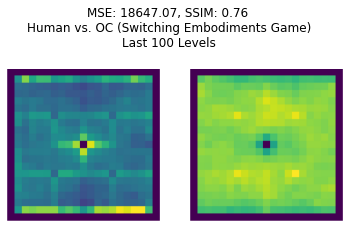

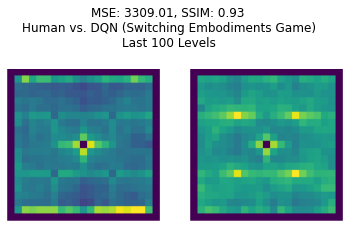

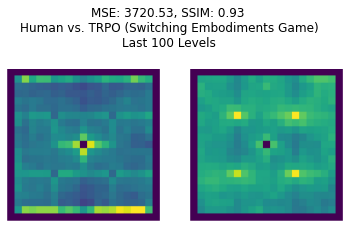

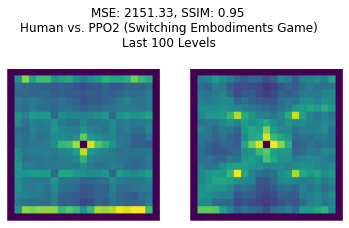

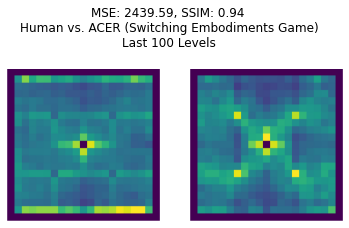

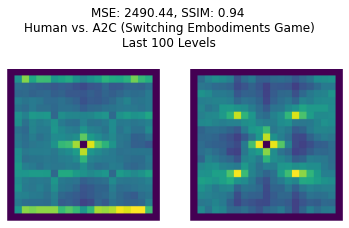

Mean MSE error for change_agent_game = 5459.661698410334 (Normalized, last_100)


In [20]:

## CALCULATE AVG. MSE COMPARED WITH HUMAN
errors_mse = {}
errors_ssim = {}

norm_errors_mse = {}
norm_errors_ssim = {}
fl100s = [1, 0, -1]


for fl100 in fl100s:
    s = ""
    tstr = ""
    if fl100 == 1:
        s = "first_100"
        tstr = "First 100 Levels"
    elif fl100 == -1:
        s = "last_100"
        tstr = "Last 100 Levels"

    # Normalized
    for game in ['change_agent_game']:
        norm_errors_mse[game] = {}
        norm_errors_ssim[game] = {}
        for agent in ['option_critic', 'dqn_training', 'trpo_training', 'ppo2_training', 'acer_training', 'a2c_training']: #'dqn_training', 'trpo_training', 'ppo2_training', 'acer_training', 'a2c_training'
            pathA = "./plots/heatmaps/" + game + "_normalized_avg/" + "human" + "/" + "{}seeds_combined_heatmap.jpg".format(s)
            pathB = "./plots/heatmaps/" + game + "_normalized_avg/" + agent + "/" + "{}seeds_combined_heatmap.jpg".format(s)

            imgA = mpimg.imread(glob.glob(pathA)[0])
            imgB = mpimg.imread(glob.glob(pathB)[0])
            title = ("Human vs. " + agent_titles[agent] + " (" + game_titles[game] + ")" + "\n{}".format(tstr)) if 'shuffled' not in game else ("Human vs. " + agent_titles[agent] + " \n" + game_titles[game] + "\n{}".format(tstr))
            msee, ssimi = compare_images(imgA, imgB, game_type=game, agent_type=agent,
                        title=title,
                        folder_appx='normalized_avg', fl100=fl100)
            norm_errors_mse[game][agent] = msee
            norm_errors_ssim[game][agent] = ssimi

    # Calculate mean errors
    for game in ['change_agent_game']:
        mean_norm_err_mse = np.array(list(norm_errors_mse[game].values())).mean()
        print("Mean MSE error for {} = {} (Normalized, {})".format(game, mean_norm_err_mse, s))


In [ ]:
### COMPARISON OF COMPARISONS (MSE)

comparisons = {}
# Initialize dictionaries:
for game in ["logic_game", "contingency_game", "contingency_game_shuffled_1"]: #"change_agent_game"
    comparisons[game] = {}
    for fl in ["first_100", "s", "last_100"]: # First Hundred, All, Last Hundred
        comparisons[game][fl] = {}
        for agent in ["option_critic", "dqn_training", "acer_training", "a2c_training", "trpo_training", "ppo2_training", "human"]:
            comparisons[game][fl][agent] = []

# Compare difference of differences:
# Comparing "Human v. Self" with "RL Algorithms v. Self" for First Hundred, All, and Last Hundred Levels:::
for game in ["logic_game", "contingency_game", "contingency_game_shuffled_1"]: #"change_agent_game"
    for fl in ["s", "first_100", "last_100"]: # All, First Hundred, Last Hundred
        print("******************** {} - {} ********************".format(game, fl))
        self_class_files = glob.glob("./plots/heatmaps/" + game + "_normalized/" + "self_class" + "/" + "{}*.jpg".format(fl))

        ############# Compare average of humans to each self class:
        human_file = glob.glob("./plots/heatmaps/" + game + "_normalized_avg/" + "human" + "/" + "seeds_combined_heatmap.jpg")[0]

        def get_seed_num(x):
            if x.split("_")[-2].isnumeric():
                return int(x.split("_")[-2])

        ############# Now compare each seed to self class, for each agent
        for agent in ["human", "option_critic", "dqn_training", "acer_training", "a2c_training", "trpo_training", "ppo2_training"]:
            if agent == "human":
                agent_files = glob.glob("./plots/heatmaps/" + game + "_normalized_avg/" + "human" + "/" + "seeds_combined_heatmap.jpg")
            else:
                agent_files = glob.glob("./plots/heatmaps/" + game + "_normalized/" + agent + "/" + "{}*.jpg".format(fl))

            sorted_agent_files = sorted(agent_files, key=get_seed_num)
            for j, self_file in enumerate(sorted(self_class_files, key=get_seed_num)):
                if agent == "human":
                    agent_file = sorted_agent_files[0]
                else:
                    agent_file = sorted_agent_files[j]
                print("Comparing: {} vs Self-Class, Seed={}, Files={}, {}...".format(agent, j, agent_file, self_file))
                imgA = mpimg.imread(glob.glob(self_file)[0])
                imgB = mpimg.imread(glob.glob(agent_file)[0])
                msee, ssimi = compare_images(imgA, imgB, game_type=game, agent_type='human',
                           title="",
                           folder_appx='normalized_avg', fl100=0, plot=False)

                print("MSE: {}".format(msee))
                comparisons[game][fl][agent].append(msee)

with open('mse_comparisons.json', 'w') as fp:
    json.dump(comparisons, fp, indent=4)

In [6]:
# PERFORM T-TESTS
comparisons = {}
with open('mse_comparisons.json', 'r') as fp:
    comparisons = json.load(fp)

results = {}
for game in ["logic_game", "contingency_game", "contingency_game_shuffled_1", "change_agent_game"]: #
    results[game] = {}
    for fl in ["first_100", "s", "last_100"]: # First Hundred, All, Last Hundred
        results[game][fl] = {}
        for agent in ["dqn_training", "acer_training", "trpo_training", "a2c_training", "ppo2_training", "option_critic"]:
            results[game][fl][agent] = {}

for fl in ["first_100", "s", "last_100"]: # First Hundred, All, Last Hundred
    for game in ["logic_game", "contingency_game", "contingency_game_shuffled_1", "change_agent_game"]: #"change_agent_game"
        print("******************** {} - {} ********************".format(game, fl))
        for agent in ["dqn_training", "acer_training", "trpo_training", "a2c_training", "ppo2_training", "option_critic"]:
            print("Comparing: {} vs Human".format(agent))
            # Perform t-tests:::
            vt = stats.var_test(R.FloatVector(comparisons[game][fl][agent]), R.FloatVector(comparisons[game][fl]["human"]))
            print(vt)

            tt = stats.t_test(R.FloatVector(comparisons[game][fl][agent]), R.FloatVector(comparisons[game][fl]["human"]),
             **{'var.equal': vt.rx('p.value')[0][0]>0.05, 'paired': False})

            sda = round(stats.sd(R.FloatVector(comparisons[game][fl][agent]))[0], 1)
            sdh = round(stats.sd(R.FloatVector(comparisons[game][fl]["human"]))[0], 1)

            print(tt)

            sig = ""
            if tt.rx('p.value')[0][0] < 0.001:
                sig = "***"
            elif tt.rx('p.value')[0][0] < 0.01:
                sig = "**"
            elif tt.rx('p.value')[0][0] < 0.05:
                sig = "*"
            elif tt.rx('p.value')[0][0] < 0.1:
                sig = "."

            mean_agent = round(pys.mean(comparisons[game][fl][agent]), 1)
            mean_human = round(pys.mean(comparisons[game][fl]["human"]), 1)
            results[game][fl][agent] = {'dof': round(tt.rx('parameter')[0][0], 1), 't-val': round(tt.rx('statistic')[0][0], 1), 'p-value': round(tt.rx('p.value')[0][0], 4), 'significance': sig, 'mean_agent': mean_agent, 'sd_agent': sda, 'mean_human': mean_human, 'sd_human': sdh, 'str': str(tt)}

with open('mse_comparison_results.json', 'w') as fp:
    json.dump(results, fp, indent=4)
print(results)

******************** logic_game - first_100 ********************
Comparing: dqn_training vs Human

	F test to compare two variances

data:  c(4442.1033333224, 4400.40013452662, 5284.41101126423, 5039.81074587018, 4490.9416531792, 7694.393224719, 5019.44519490221, 4411.75264656178, 4903.52833456083, 5800.45207105228, 4629.71013760067, 6753.33437217201, 5822.35319157236, 4607.2500217048, 4978.57814306666, 5478.47225159826, 5902.7070188408, 7384.59864465383, 4682.72319517458, 6468.2641416489) and c(3097.53322457056, 2166.13298458364, 2499.44014488969, 2962.51794093843, 2178.79435102126, 2501.32560653916, 3115.70956749365, 2749.71220986981, 2602.83448824739, 4022.9973862759, 3754.34023238204, 3345.64235165092, 2691.59152012833, 3050.30923033135, 2526.68937158602, 3274.11849112709, 4065.71781790716, 2483.04568519771, 2281.17024918147, 2859.19924075483)
F = 3.1418, num df = 19, denom df = 19, p-value = 0.01637
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confi